In [1]:
import os
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from python.data import Dataloader
from python.models import RandomExampleModel
from python.metrics import PairsExplained, ClusterIntersection

In [3]:
# Loading the data
data_loader = Dataloader("../data/dataset_10") # Specify path to the dataset you want to load
X, Y = data_loader.load()
Z = data_loader.get_ground_truth_labels()
print(X.shape)
print(Y.shape)
print(Z.shape)

(40002, 10)
(40002, 10)
(40002,)


In [4]:
# Let's train an example model
model = RandomExampleModel() # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data
print(X.shape)

(40002, 10)


In [5]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[-0.0172     -0.17280946]
 [ 0.1904899   0.05389895]
 [-0.18002516 -0.11719372]
 [ 0.24068762  0.22920997]
 [ 0.14951786  0.09248784]]


In [6]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]]


In [7]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 0.4


In [8]:
# Or we call directly the right metric:
pairs_explained = PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.6719664016799161
Percentage of explained preferences for all samples: 0.6719664016799161


In [9]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[0 0 1 0 0]


In [10]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
# We can see how it compares to our model's predictions:
print(Z[:5])

[1 0 2 1 0]


In [11]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 0.6
Cluster intersection for all samples: 0.5236179280008775
Cluster intersection for all samples: 0.5236179280008775


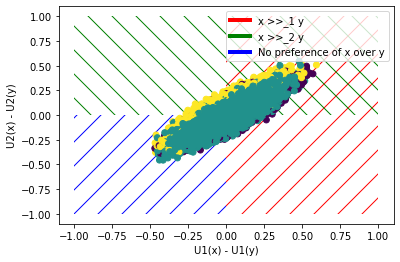

In [12]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

In [14]:
from python.models import HeuristicModel

matrix_results = []
for cluster in range(2, 10):
    list_temp = []
    for l in range(5, 10):
        model = HeuristicModel(n_clusters=cluster, n_pieces=l, nb_iterations=5)
        model.fit(X[:200], Y[:200])
        list_temp.append([pairs_explained.from_model(model, X, Y), cluster_intersection.from_model(model, X, Y, Z)])
    matrix_results.append(list_temp)
print(matrix_results)

# Uncomment once your model is working
print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 265 rows, 570 columns and 4080 nonzeros
Model fingerprint: 0x2e27723b
Variable types: 468 continuous, 102 integer (102 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 9.0951214
Presolve removed 122 rows and 418 columns
Presolve time: 0.00s
Presolved: 143 rows, 152 columns, 3174 nonzeros
Found heuristic solution: objective 5.5873994
Variable types: 152 continuous, 0 integer (0 binary)

Root relaxation: objective 6.293598e-01, 146 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth

In [18]:
matrix_results_temp = [[[0.8316334183290836, 0.5515081362003998], [0.8323083845807709, 0.5097614285056603], [0.8191590420478976, 0.5096678655230009], [0.8021098945052747, 0.5070037253368451], [0.8263586820658967, 0.515264555764237]], [[0.8820808959552022, 0.579856727520615], [0.8862056897155143, 0.5615577149694302], [0.8848307584620769, 0.5740439759842462], [0.9052047397630119, 0.5619870952653713], [0.9033298335083246, 0.5652114509346656]], [[0.9286285685715714, 0.5881918386268632], [0.9214039298035098, 0.5933340717029547], [0.9356282185890705, 0.5870495130527091], [0.9171041447927604, 0.5975502042377444], [0.903904804759762, 0.596889847515324]], [[0.9388780560971951, 0.6124469494632315], [0.9491025448727564, 0.5991719926015899], [0.9285285735713215, 0.6036116008754199], [0.9407279636018199, 0.6079771309552069], [0.9375781210939453, 0.6121938596952805]], [[0.9533523323833808, 0.6107819568397596], [0.9650517474126293, 0.620176063520016], [0.9670516474176292, 0.6134396600086998], [0.9653767311634418, 0.6171800094778142], [0.9633518324083796, 0.6260746161211976]], [[0.9530273486325683, 0.6287490217874296], [0.9647017649117544, 0.6478451870511647], [0.9614019299035048, 0.626767210425759], [0.9756512174391281, 0.6234982331031445], [0.9433778311084445, 0.6265004579325295]], [[0.9712264386780661, 0.6360144056245601], [0.9697265136743163, 0.6237766434720188], [0.9664516774161291, 0.6312091472749429], [0.964176791160442, 0.626228622070559], [0.9699015049247538, 0.6295294732525942]], [[0.9747262636868157, 0.627525872275172], [0.97977601119944, 0.6356242886338221], [0.9779011049447528, 0.6294262397452363], [0.9825508724563772, 0.6427337216674578], [0.97997600119994, 0.6194931934861221]]]
matrix_temp_2 = []
for cluster in range(len(matrix_results_temp)):
    list_temp = []
    for l in range(len(matrix_results_temp[0])):
        list_temp.append(matrix_results_temp[cluster][l][0]+matrix_results_temp[cluster][l][1])
    matrix_temp_2.append(list_temp)
matrix_temp_2 = np.array(matrix_temp_2)
print(matrix_temp_2)
print(np.argmax(matrix_temp_2)) # l = 8 et k = 9

# c'est normal que la précision augmente avec L parce que le modèle est plus flexible mais du coup on va fixer L
# on va augmenter le nombre de clusters (pour tester si ça marche tjs)
# on va augmenter le nombre de données à prendre en compte

[[1.38314155 1.34206981 1.32882691 1.30911362 1.34162324]
 [1.46193762 1.4477634  1.45887473 1.46719184 1.46854128]
 [1.51682041 1.514738   1.52267773 1.51465435 1.50079465]
 [1.55132501 1.54827454 1.53214017 1.54870509 1.54977198]
 [1.56413429 1.58522781 1.58049131 1.58255674 1.58942645]
 [1.58177637 1.61254695 1.58816914 1.59914945 1.56987829]
 [1.60724084 1.59350316 1.59766082 1.59040541 1.59943098]
 [1.60225214 1.6154003  1.60732734 1.62528459 1.59946919]]
38


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# # This cell should work when you have completed the TwoClustersMIP model
# from python.models import TwoClustersMIP

# model = TwoClustersMIP(n_clusters=2, n_pieces=5)
# model.fit(X, Y)

# # Uncomment once your model is working
# print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
# print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 120128 rows, 240132 columns and 3106140 nonzeros
Model fingerprint: 0x382fde12
Variable types: 160128 continuous, 80004 integer (80004 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 3285.0528426
Presolve removed 40042 rows and 160028 columns (presolve time = 5s) ...
Presolve removed 40042 rows and 160028 columns (presolve time = 10s) ...
Presolve removed 40042 rows and 160028 columns
Presolve time: 12.09s
Presolved: 80086 rows, 80104 columns, 2496592 nonzeros


KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "c:\Software\Dev\Python_396\lib\site-packages\ipykernel\iostream.py", line 525, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]
KeyboardInterrupt: 


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.88s

Barrier statistics:
 Dense cols : 100
 AA' NZ     : 2.377e+06
 Factor NZ  : 4.798e+06 (roughly 110 MB of memory)
 Factor Ops : 2.895e+08 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.56836166e+06 -5.39651543e+05  5.04e+01 0.00e+00  4.83e+01    18s
   1   1.20126101e+06 -6.30354254e+05  2.93e+01 3.35e+00  2.69e+01    18s
   2   8.57756287e+05 -6.34640952e+05  1.89e+01 1.65e-01  1.52e+01    19s
   3   2.34961091e+05 -3.81640004e+05  3.64e+00 1.07e-02  3.55e+00    19s

Barrier performed 3 iterations in 19.12 seconds (5.44 work units)
Barrier solve interrupted - model solved by another algorithm

Concurrent spin time: 1.39s (can be avoided by choosing Method=3)

Solved with primal simplex

Root simple

In [ ]:
print(X[0], Y[0])
print(model.compute_score(X[0], 0, evaluate=True))
print(model.compute_score(X[0], 1, evaluate=True))
print(model.compute_score(Y[0], 0, evaluate=True))
print(model.compute_score(Y[0], 1, evaluate=True))

print("Non null errors")
for sigma in model.sigma_x_minus:
    if sigma.X != 0:
        print(sigma.X)
for sigma in model.sigma_x_plus:
    if sigma.X != 0:
        print(sigma.X)
for sigma in model.sigma_y_plus:
    if sigma.X != 0:
        print(sigma.X)
for sigma in model.sigma_y_minus:
    if sigma.X != 0:
        print(sigma.X)

# for delta_j in model.delta_j_k:
#     for delta_j_k in delta_j:
#         print(delta_j_k.X)

print("Functions")
for score_k in model.score_k_i_l:
    for score_k_i in score_k:
        for score_k_i_l in score_k_i:
            print(score_k_i_l.X)
        print("--------")
    print("CHANGE CLUSTER")

[0.45360563 0.25691407 0.71509031 0.90380217] [0.5571581  0.83223381 0.79529317 0.11810177]
0.9655626668251982
0.9602209539269769
0.9832916479937892
0.8168857806222548
Non null errors
Functions
0.0
0.009056594667690704
0.009056594667690704
0.01400139580504693
0.016018367040083012
0.016018367040083012
--------
0.0
0.3795676953153694
0.3948899037068375
0.3972548464388774
0.3972548464388774
0.3993411347210092
--------
0.0
0.10598443916687503
0.5202631370460438
0.5683361677624402
0.5728649655326379
0.5843299853930785
--------
0.0
0.0
0.0
0.0003105128458293499
0.0003105128458293499
0.0003105128458293499
--------
CHANGE CLUSTER
0.0
0.1562798715740308
0.22754554595011367
0.22754554595011367
0.22802270084608517
0.24164819681811978
--------
0.0
0.0
0.0044380432550882734
0.0044380432550882734
0.0044380432550882734
0.006809544446718443
--------
0.0
0.33054346691542347
0.3358943517498328
0.4617493581090982
0.46842000006121604
0.4846779612354869
--------
0.0
0.19687590991450413
0.20744300860857218


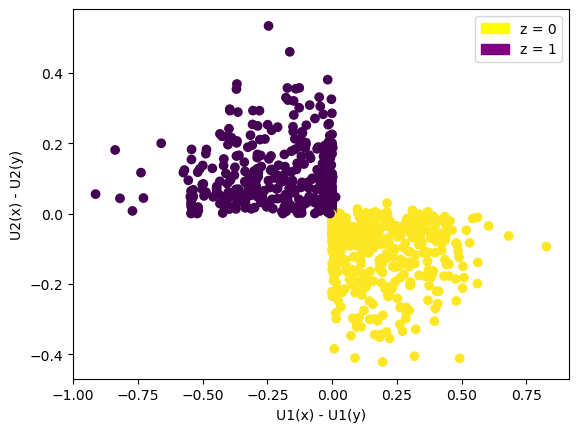

In [ ]:
# As an example here are the results obtained with:
""" # Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()
"""
# Here is how it should look like
from IPython.display import Image
Image("../images/MIP_results_example.png")

Your second assignement will be to find another model that will work well with larger data instances.